# Descarga de datos de Fallecimientos desde Sanidad

## Objetivo

Vamos a hacer una lectura de los fallecimientos comunicados por sanidad en cada uno de los pdf que publica

## Código

Tenemos un montón de librerias con las que vamos a trabajar, no he tenido ningún problema en instalar aquellas no disponibles en el entorno Anaconda con el que trabajo por medio de `pip install libreria` realizado desde un terminal abierto desde el entorno `env`.

In [3]:
import os.path as pth
import datetime as dt
import time
from glob import glob
import re
import pandas as pd
import numpy as np

import requests
from shutil import copyfile

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, WeekdayLocator, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)
import seaborn as sns
import matplotlib.colors as colors

import numpy as np
from datetime import datetime
import seaborn as sns
%matplotlib inline

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO

Preparamos las expresiones regulares que nos ayudarán en la interpretación de la información que sacamos de los pdf.

Definimos variables que nos ayuden en la gestión de los nombres de los ficheros.

In [1]:
datadir='datos_sanidad/'
path_sanidad_pdf='datos_sanidad.csv'
path_sanidad='https://cnecovid.isciii.es/covid19/resources/casos_diagnostico_provincia.csv'

# Descargamos el csv de sanidad

In [16]:
datos=pd.read_csv(path_sanidad,encoding = "ISO-8859-1")

In [17]:
datos

,provincia_iso,fecha,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_ag,num_casos_prueba_elisa,num_casos_prueba_desconocida
0,A,2020-01-01,0,0,0,0,0,0
1,AB,2020-01-01,0,0,0,0,0,0
2,AL,2020-01-01,0,0,0,0,0,0
3,AV,2020-01-01,0,0,0,0,0,0
4,B,2020-01-01,6,6,0,0,0,0
...,...,...,...,...,...,...,...,...
19605,V,2021-01-04,0,0,0,0,0,0
19606,VA,2021-01-04,0,0,0,0,0,0
19607,VI,2021-01-04,2,0,0,2,0,0
19608,Z,2021-01-04,0,0,0,0,0,0


In [21]:
datos_madrid = datos[datos['provincia_iso']=='M']

In [23]:
datos_madrid.tail(10)

,provincia_iso,fecha,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_ag,num_casos_prueba_elisa,num_casos_prueba_desconocida
19107,M,2020-12-26,1421,538,0,883,0,0
19160,M,2020-12-27,1266,444,0,822,0,0
19213,M,2020-12-28,1984,729,0,1255,0,0
19266,M,2020-12-29,2695,1200,0,1495,0,0
19319,M,2020-12-30,2896,1751,0,1145,0,0
19372,M,2020-12-31,867,488,0,379,0,0
19425,M,2021-01-01,513,214,0,299,0,0
19478,M,2021-01-02,727,313,0,414,0,0
19531,M,2021-01-03,578,237,0,341,0,0
19584,M,2021-01-04,0,0,0,0,0,0


In [28]:
datos_madrid[datos_madrid['fecha']=='2020-12-30']

,provincia_iso,fecha,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_ag,num_casos_prueba_elisa,num_casos_prueba_desconocida
19319,M,2020-12-30,2896,1751,0,1145,0,0


In [241]:
datos['Comunidad']=datos.apply(lambda x:codigo_comunidad[x['CCAA_ISO']],axis=1)

In [242]:
datos

,CCAA_ISO,Fecha,Casos_Diagnosticados,Hospitalizados,UCI,Fallecidos,Comunidad
0,ES-AN,01-01-2020,0,1,0,0,Andalucia
1,ES-AR,01-01-2020,1,0,0,0,Aragon
2,ES-CT,01-01-2020,0,1,0,0,Cataluña
3,ES-GA,01-01-2020,0,1,0,0,Galicia
4,ES-MD,01-01-2020,0,1,0,0,Madrid
...,...,...,...,...,...,...,...
5137,ES-ML,26-11-2020,18,1,0,1,Melilla
5138,ES-NC,26-11-2020,162,9,2,3,Navarra
5139,ES-PV,26-11-2020,388,0,0,1,Pais Vasco
5140,ES-RI,26-11-2020,63,9,0,0,La Rioja


In [243]:
for i in datos['CCAA_ISO'].unique():
    datos.loc[datos['CCAA_ISO']==i,'Fallecidos_acumulados']=datos.loc[datos['CCAA_ISO']==i,'Fallecidos'].cumsum()

In [244]:
datos.loc[datos['CCAA_ISO']=='ES-AN',:].tail(20)

,CCAA_ISO,Fecha,Casos_Diagnosticados,Hospitalizados,UCI,Fallecidos,Comunidad,Fallecidos_acumulados
4762,ES-AN,07-11-2020,3165,213,12,36,Andalucia,2942.0
4781,ES-AN,08-11-2020,1866,176,16,40,Andalucia,2982.0
4800,ES-AN,09-11-2020,3701,248,11,49,Andalucia,3031.0
4819,ES-AN,10-11-2020,4353,214,23,48,Andalucia,3079.0
4838,ES-AN,11-11-2020,4376,230,15,51,Andalucia,3130.0
4857,ES-AN,12-11-2020,4275,205,12,49,Andalucia,3179.0
4876,ES-AN,13-11-2020,4131,180,9,42,Andalucia,3221.0
4895,ES-AN,14-11-2020,2290,171,4,48,Andalucia,3269.0
4914,ES-AN,15-11-2020,1359,133,13,39,Andalucia,3308.0
4933,ES-AN,16-11-2020,2386,192,17,36,Andalucia,3344.0


In [245]:
datos['Fecha']=pd.to_datetime(datos['Fecha'],format='%d-%m-%Y')

In [265]:
sanidad_pdf=pd.read_csv(path_sanidad_pdf,index_col=0)

In [266]:
#nombre_columnas=list(sanidad_pdf.columns)
#nombre_columnas[0]='Fecha'
#sanidad_pdf.columns=nombre_columnas

In [267]:
sanidad_pdf

,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,...,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25,2020-11-26,2020-11-27
Andalucia,912,940,967,993,1013,1017,1050,1079,1107,1131,...,3264,3354,3424,3472,3527,3633,3725,3790,3842,3903
Aragon,543,562,601,619,637,643,656,681,695,709,...,2039,2067,2106,2129,2148,2189,2208,2227,2251,2279
Asturias,168,174,187,196,200,202,211,223,231,239,...,732,739,755,775,800,857,883,904,929,954
Baleares,131,134,148,155,157,161,164,168,172,174,...,391,397,397,398,398,398,399,402,404,404
Canarias,107,111,115,119,119,120,121,121,128,130,...,312,318,319,321,322,326,333,334,336,339
Cantabria,137,144,149,153,158,165,167,173,178,182,...,279,282,291,292,293,297,297,298,300,304
Castilla La Mancha,1796,1852,1913,1963,2021,2075,2140,2188,2255,2292,...,3574,3584,3597,3635,3659,3687,3693,3722,3738,3761
Castilla y Leon,1372,1401,1429,1458,1493,1521,1554,1582,1612,1639,...,4122,4188,4237,4253,4293,4343,4394,4434,4463,4487
Cataluña,3855,3752,3879,3933,4009,4152,4247,4343,4393,4498,...,7382,7410,7426,7450,7495,7596,7692,7793,7850,7911
Ceuta,4,4,4,4,4,4,4,4,4,4,...,46,46,45,45,46,49,51,52,52,54


In [268]:
#sanidad_pdf.set_index('Fecha',inplace=True)

In [269]:
sanidad_pdf=sanidad_pdf.T

In [277]:
sanidad_pdf.index

DatetimeIndex(['2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
               '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23',
               '2020-04-24', '2020-04-25',
               ...
               '2020-11-13', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-23', '2020-11-24',
               '2020-11-25', '2020-11-26'],
              dtype='datetime64[ns]', length=183, freq=None)

In [271]:
sanidad_pdf

,Andalucia,Aragon,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y Leon,Cataluña,Ceuta,C.Valenciana,Extremadura,Galicia,Madrid,Melilla,Murcia,Navarra,Pais Vasco,La Rioja
2020-04-16,912,543,168,131,107,137,1796,1372,3855,4,972,359,310,6877,2,111,261,956,257
2020-04-17,940,562,174,134,111,144,1852,1401,3752,4,999,372,320,7007,2,112,338,992,262
2020-04-18,967,601,187,148,115,149,1913,1429,3879,4,1042,380,334,7132,2,115,354,1020,272
2020-04-19,993,619,196,155,119,153,1963,1458,3933,4,1065,384,346,7239,2,116,369,1062,277
2020-04-20,1013,637,200,157,119,158,2021,1493,4009,4,1079,389,352,7351,2,117,385,1081,285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,3633,2189,857,398,326,297,3687,4343,7596,49,2188,895,1153,11211,36,555,845,2343,530
2020-11-24,3725,2208,883,399,333,297,3693,4394,7692,51,2237,902,1172,11250,37,566,850,2446,533
2020-11-25,3790,2227,904,402,334,298,3722,4434,7793,52,2262,909,1173,11279,38,583,853,2447,537
2020-11-26,3842,2251,929,404,336,300,3738,4463,7850,52,2288,915,1178,11349,39,589,856,2452,543


In [272]:
sanidad_pdf=sanidad_pdf.shift(periods=-1).drop(['2020-11-27'])


In [275]:
sanidad_pdf.index = pd.to_datetime(sanidad_pdf.index)

In [276]:
sanidad_pdf

,Andalucia,Aragon,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y Leon,Cataluña,Ceuta,C.Valenciana,Extremadura,Galicia,Madrid,Melilla,Murcia,Navarra,Pais Vasco,La Rioja
2020-04-16,940.0,562.0,174.0,134.0,111.0,144.0,1852.0,1401.0,3752.0,4.0,999.0,372.0,320.0,7007.0,2.0,112.0,338.0,992.0,262.0
2020-04-17,967.0,601.0,187.0,148.0,115.0,149.0,1913.0,1429.0,3879.0,4.0,1042.0,380.0,334.0,7132.0,2.0,115.0,354.0,1020.0,272.0
2020-04-18,993.0,619.0,196.0,155.0,119.0,153.0,1963.0,1458.0,3933.0,4.0,1065.0,384.0,346.0,7239.0,2.0,116.0,369.0,1062.0,277.0
2020-04-19,1013.0,637.0,200.0,157.0,119.0,158.0,2021.0,1493.0,4009.0,4.0,1079.0,389.0,352.0,7351.0,2.0,117.0,385.0,1081.0,285.0
2020-04-20,1017.0,643.0,202.0,161.0,120.0,165.0,2075.0,1521.0,4152.0,4.0,1089.0,397.0,360.0,7460.0,2.0,120.0,397.0,1103.0,294.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-20,3633.0,2189.0,857.0,398.0,326.0,297.0,3687.0,4343.0,7596.0,49.0,2188.0,895.0,1153.0,11211.0,36.0,555.0,845.0,2343.0,530.0
2020-11-23,3725.0,2208.0,883.0,399.0,333.0,297.0,3693.0,4394.0,7692.0,51.0,2237.0,902.0,1172.0,11250.0,37.0,566.0,850.0,2446.0,533.0
2020-11-24,3790.0,2227.0,904.0,402.0,334.0,298.0,3722.0,4434.0,7793.0,52.0,2262.0,909.0,1173.0,11279.0,38.0,583.0,853.0,2447.0,537.0
2020-11-25,3842.0,2251.0,929.0,404.0,336.0,300.0,3738.0,4463.0,7850.0,52.0,2288.0,915.0,1178.0,11349.0,39.0,589.0,856.0,2452.0,543.0


# Preparamos el CSV de Sanidad

In [246]:
sanidad_csv=datos.copy()

In [247]:
sanidad_csv.drop(['CCAA_ISO'],axis='columns',inplace=True)

In [248]:
sanidad_csv=sanidad_csv.groupby(['Fecha','Comunidad']).sum()

In [249]:
sanidad_csv=sanidad_csv[sanidad_csv.columns[-1]]

In [250]:
sanidad_csv=sanidad_csv.reset_index()

In [251]:
sanidad_csv=pd.pivot_table(sanidad_csv,index='Fecha',columns='Comunidad',aggfunc=sum)


In [252]:
sanidad_csv.columns=sanidad_csv.columns.droplevel()


In [253]:
#sanidad_csv.loc[:,:]=sanidad_csv.loc[:,:].cumsum()

In [254]:
sanidad_csv.loc['2020-11-19',:].sum()

43095.0

In [116]:
sanidad_csv

Comunidad,Andalucia,Aragon,Asturias,Baleares,C.Valenciana,Canarias,Cantabria,Castilla La Mancha,Castilla y Leon,Cataluña,Ceuta,Extremadura,Galicia,La Rioja,Madrid,Melilla,Murcia,Navarra,Pais Vasco
Fecha,,,,,,,,,,,,,,,,,,,
2020-01-01,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-22,3581.0,2199.0,856.0,402.0,2248.0,329.0,297.0,3639.0,4414.0,7898.0,54.0,898.0,1154.0,530.0,11265.0,38.0,572.0,849.0,2451.0
2020-11-23,3619.0,2221.0,883.0,402.0,2265.0,334.0,297.0,3649.0,4439.0,7906.0,54.0,904.0,1164.0,533.0,11272.0,38.0,579.0,851.0,2454.0
2020-11-24,3642.0,2242.0,906.0,404.0,2284.0,334.0,298.0,3655.0,4470.0,7909.0,54.0,913.0,1169.0,538.0,11275.0,39.0,587.0,854.0,2460.0


In [117]:
sanidad_pdf

Fecha,Andalucia,Aragon,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y Leon,Cataluña,Ceuta,C.Valenciana,Extremadura,Galicia,Madrid,Melilla,Murcia,Navarra,Pais Vasco,La Rioja
2020-04-16,940.0,562.0,174.0,134.0,111.0,144.0,1852.0,1401.0,3752.0,4.0,999.0,372.0,320.0,7007.0,2.0,112.0,338.0,992.0,262.0
2020-04-17,967.0,601.0,187.0,148.0,115.0,149.0,1913.0,1429.0,3879.0,4.0,1042.0,380.0,334.0,7132.0,2.0,115.0,354.0,1020.0,272.0
2020-04-18,993.0,619.0,196.0,155.0,119.0,153.0,1963.0,1458.0,3933.0,4.0,1065.0,384.0,346.0,7239.0,2.0,116.0,369.0,1062.0,277.0
2020-04-19,1013.0,637.0,200.0,157.0,119.0,158.0,2021.0,1493.0,4009.0,4.0,1079.0,389.0,352.0,7351.0,2.0,117.0,385.0,1081.0,285.0
2020-04-20,1017.0,643.0,202.0,161.0,120.0,165.0,2075.0,1521.0,4152.0,4.0,1089.0,397.0,360.0,7460.0,2.0,120.0,397.0,1103.0,294.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-20,3633.0,2189.0,857.0,398.0,326.0,297.0,3687.0,4343.0,7596.0,49.0,2188.0,895.0,1153.0,11211.0,36.0,555.0,845.0,2343.0,530.0
2020-11-23,3725.0,2208.0,883.0,399.0,333.0,297.0,3693.0,4394.0,7692.0,51.0,2237.0,902.0,1172.0,11250.0,37.0,566.0,850.0,2446.0,533.0
2020-11-24,3790.0,2227.0,904.0,402.0,334.0,298.0,3722.0,4434.0,7793.0,52.0,2262.0,909.0,1173.0,11279.0,38.0,583.0,853.0,2447.0,537.0
2020-11-25,3842.0,2251.0,929.0,404.0,336.0,300.0,3738.0,4463.0,7850.0,52.0,2288.0,915.0,1178.0,11349.0,39.0,589.0,856.0,2452.0,543.0


In [118]:
sanidad_pdf.loc['2020-04-16','Madrid']

7007.0

In [119]:
sanidad_csv.loc['2020-04-16','Madrid']

6526.0

# Vamos a preparar una matriz con las diferencias entre las dos series

In [278]:
dif=(sanidad_csv-sanidad_pdf)

In [279]:
dif

,Andalucia,Aragon,Asturias,Baleares,C.Valenciana,Canarias,Cantabria,Castilla La Mancha,Castilla y Leon,Cataluña,Ceuta,Extremadura,Galicia,La Rioja,Madrid,Melilla,Murcia,Navarra,Pais Vasco
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-23,-106.0,13.0,0.0,3.0,28.0,1.0,0.0,-44.0,45.0,214.0,3.0,2.0,-8.0,0.0,22.0,1.0,13.0,1.0,8.0
2020-11-24,-148.0,15.0,2.0,2.0,22.0,0.0,0.0,-67.0,36.0,116.0,2.0,4.0,-4.0,1.0,-4.0,1.0,4.0,1.0,13.0
2020-11-25,-174.0,20.0,0.0,0.0,6.0,0.0,0.0,-75.0,18.0,61.0,2.0,3.0,-6.0,0.0,-71.0,0.0,4.0,4.0,14.0


In [280]:
dif=dif.stack().reset_index()

In [281]:
dif

,level_0,level_1,0
0,2020-04-16,Andalucia,129.0
1,2020-04-16,Aragon,62.0
2,2020-04-16,Asturias,13.0
3,2020-04-16,Baleares,25.0
4,2020-04-16,C.Valenciana,117.0
...,...,...,...
3234,2020-11-26,Madrid,-74.0
3235,2020-11-26,Melilla,0.0
3236,2020-11-26,Murcia,-3.0
3237,2020-11-26,Navarra,0.0


In [282]:
dif.columns=['Fecha','Comunidad','Fallecidos']

In [283]:
dif

,Fecha,Comunidad,Fallecidos
0,2020-04-16,Andalucia,129.0
1,2020-04-16,Aragon,62.0
2,2020-04-16,Asturias,13.0
3,2020-04-16,Baleares,25.0
4,2020-04-16,C.Valenciana,117.0
...,...,...,...
3234,2020-11-26,Madrid,-74.0
3235,2020-11-26,Melilla,0.0
3236,2020-11-26,Murcia,-3.0
3237,2020-11-26,Navarra,0.0


In [284]:
serie_pdf = sanidad_pdf.stack().reset_index()
serie_pdf.columns=['Fecha','Comunidad','Fallecidos']

In [285]:
serie_pdf

,Fecha,Comunidad,Fallecidos
0,2020-04-16,Andalucia,940.0
1,2020-04-16,Aragon,562.0
2,2020-04-16,Asturias,174.0
3,2020-04-16,Baleares,134.0
4,2020-04-16,Canarias,111.0
...,...,...,...
3472,2020-11-26,Melilla,40.0
3473,2020-11-26,Murcia,597.0
3474,2020-11-26,Navarra,863.0
3475,2020-11-26,Pais Vasco,2467.0


In [286]:
serie_csv = sanidad_csv.stack().reset_index()
serie_csv.columns=['Fecha','Comunidad','Fallecidos']

In [287]:
serie_csv

,Fecha,Comunidad,Fallecidos
0,2020-01-01,Andalucia,0.0
1,2020-01-01,Aragon,0.0
2,2020-01-01,C.Valenciana,0.0
3,2020-01-01,Cataluña,0.0
4,2020-01-01,Galicia,0.0
...,...,...,...
5137,2020-11-26,Madrid,11278.0
5138,2020-11-26,Melilla,40.0
5139,2020-11-26,Murcia,594.0
5140,2020-11-26,Navarra,863.0


In [288]:
serie_pdf['Fecha']

0      2020-04-16
1      2020-04-16
2      2020-04-16
3      2020-04-16
4      2020-04-16
          ...    
3472   2020-11-26
3473   2020-11-26
3474   2020-11-26
3475   2020-11-26
3476   2020-11-26
Name: Fecha, Length: 3477, dtype: datetime64[ns]

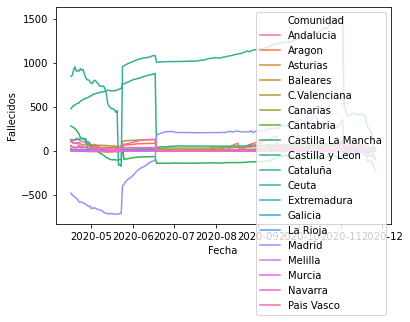

In [131]:
import seaborn as sns

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
sns.lineplot(x='Fecha', y="Fallecidos",
             hue="Comunidad",
             data=dif)

In [289]:
serie_csv['Fecha']

0      2020-01-01
1      2020-01-01
2      2020-01-01
3      2020-01-01
4      2020-01-01
          ...    
5137   2020-11-26
5138   2020-11-26
5139   2020-11-26
5140   2020-11-26
5141   2020-11-26
Name: Fecha, Length: 5142, dtype: datetime64[ns]

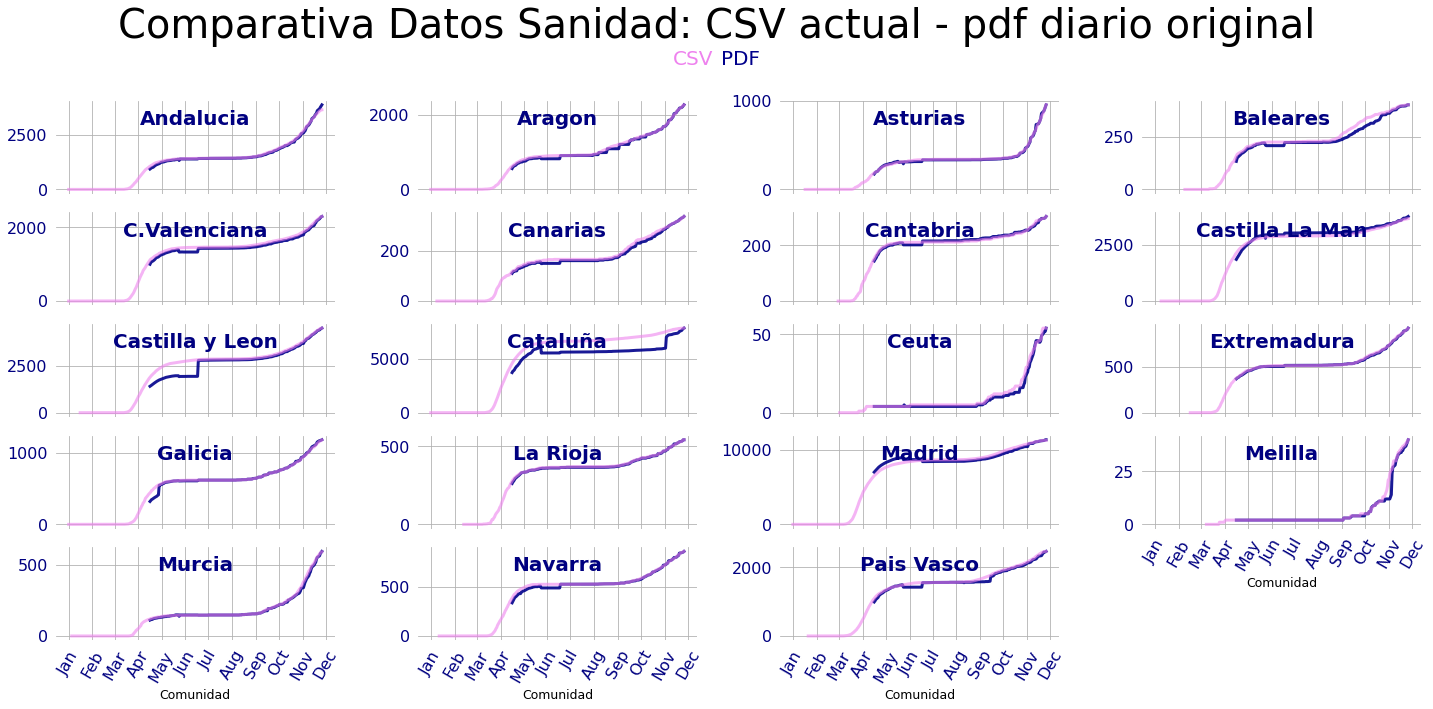

In [345]:

titulo='Comparativa Datos Sanidad: CSV actual - pdf diario original'
pal = sns.cubehelix_palette(52, rot=-.25, light=.7)
with sns.plotting_context('paper',font_scale=1.3):
    g = sns.FacetGrid(dif,col='Comunidad', hue='Comunidad',col_wrap=4,aspect=2.5, sharex=True,
                        margin_titles=False,height=2, 
                        sharey=False,palette=pal,legend_out=True)
    
def grafica(x, color, label):
    ax1 = plt.gca()
    #ax2=ax1.twinx()
    ax1.text(0.5, .8, label[0:15], fontweight="bold", color='navy',
            ha="center", va="center", size=20,transform=ax1.transAxes)
    sns.lineplot(serie_pdf.loc[serie_pdf['Comunidad']==label,'Fecha'], 
                 serie_pdf.loc[serie_pdf['Comunidad']==label,'Fallecidos'],
                 color='darkblue',alpha=.9,ax=ax1,lw=3,label='PDF',legend='full')
    sns.lineplot(serie_csv.loc[serie_csv['Comunidad']==label,'Fecha'], 
                 serie_csv.loc[serie_csv['Comunidad']==label,'Fallecidos'],
                 color='violet',alpha=.6,ax=ax1,lw=3,label='csv',legend='full')
    ax1.legend()
   
    #ax1.set_xlim(-1,7)
     #    #ax1.set_yticks(ax1.get_yticks()[1:-2])
    ax1.yaxis.set_tick_params(labelsize=16,labelcolor='navy',width=0,rotation=0) 
    ax1.xaxis.set_tick_params(labelsize=16,labelcolor='navy',width=0,rotation=60) 
    #ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:.1f}{}'.format(v/escala[0],escala[1])))
    ax1.set_ylabel('')
    #ax1.axhline(y=0,color='red')
    ax1.grid(True)
    #sns.lineplot(dif.loc[dif['Comunidad']==label,'Fecha'], 
    #             dif.loc[dif['Comunidad']==label,'Fallecidos'],color='magenta',alpha=.6,ax=ax2)
    #ax2.set_ylim(min(0,dif.loc[dif['Comunidad']==label,'Fallecidos'].min()),max(0,dif.loc[dif['Comunidad']==label,'Fallecidos'].max()*1.5))
   
    XmajorFmt = DateFormatter('%b')
    ax1.xaxis.set_major_formatter(XmajorFmt)
    #ax2.yaxis.set_tick_params(labelsize=10,labelcolor='magenta',width=0,rotation=0) 
    #ax2.set_ylabel('')
    #ax2.grid(False)
    #ax2.axhline(y=0,color='red')

g.map(grafica,'Comunidad')


g.fig.subplots_adjust(hspace=0)

g.set_titles("")
    
g.despine(bottom=True, left=True)
#g.fig.suptitle('{}'.format(titulo),fontsize=26,color='navy')
g.fig.suptitle(titulo,
                fontsize=40)
g.fig.text(0.53, 0.9, "PDF", fontsize=20, color='darkblue', ha ='right')
g.fig.text(0.47, 0.9, "CSV", fontsize=20, color='violet', ha ='left')
g.fig.subplots_adjust(top=.85,wspace=.3,hspace=.2)   
  
plt.savefig('graficos/comparativa_sanidad_pdf_csv',dpi=144)  
plt.show()

    


In [ ]:
g.fig.

In [64]:
sanidad_pdf.loc['2020-11-26'].sum()

44374

In [58]:
sanidad_pdf.loc['2020-11-27'].sum()

44668

In [59]:
sanidad_pdf

Fecha,Andalucia,Aragon,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y Leon,Cataluña,Ceuta,C.Valenciana,Extremadura,Galicia,Madrid,Melilla,Murcia,Navarra,Pais Vasco,La Rioja
2020-04-16,912,543,168,131,107,137,1796,1372,3855,4,972,359,310,6877,2,111,261,956,257
2020-04-17,940,562,174,134,111,144,1852,1401,3752,4,999,372,320,7007,2,112,338,992,262
2020-04-18,967,601,187,148,115,149,1913,1429,3879,4,1042,380,334,7132,2,115,354,1020,272
2020-04-19,993,619,196,155,119,153,1963,1458,3933,4,1065,384,346,7239,2,116,369,1062,277
2020-04-20,1013,637,200,157,119,158,2021,1493,4009,4,1079,389,352,7351,2,117,385,1081,285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,3633,2189,857,398,326,297,3687,4343,7596,49,2188,895,1153,11211,36,555,845,2343,530
2020-11-24,3725,2208,883,399,333,297,3693,4394,7692,51,2237,902,1172,11250,37,566,850,2446,533
2020-11-25,3790,2227,904,402,334,298,3722,4434,7793,52,2262,909,1173,11279,38,583,853,2447,537
2020-11-26,3842,2251,929,404,336,300,3738,4463,7850,52,2288,915,1178,11349,39,589,856,2452,543


In [135]:
(sanidad_csv.loc['2020-11-26']-sanidad_pdf.loc['2020-11-26'])

Andalucia            -230.0
Aragon                 -2.0
Asturias                0.0
Baleares                0.0
C.Valenciana            0.0
Canarias                0.0
Cantabria               0.0
Castilla La Mancha    -95.0
Castilla y Leon         0.0
Cataluña                0.0
Ceuta                   0.0
Extremadura            -1.0
Galicia                -2.0
La Rioja                0.0
Madrid                -74.0
Melilla                 0.0
Murcia                 -3.0
Navarra                 0.0
Pais Vasco              0.0
dtype: float64

In [76]:
dif[dif['Fecha']=='2020-11-27']

,Fecha,Comunidad,Fallecidos


In [81]:
(sanidad_pdf.loc['2020-11-27']-sanidad_pdf.loc['2020-11-26']).sum()

294

In [136]:
sanidad_pdf.loc['2020-11-26']

Fecha
Andalucia              3903.0
Aragon                 2279.0
Asturias                954.0
Baleares                404.0
Canarias                339.0
Cantabria               304.0
Castilla La Mancha     3761.0
Castilla y Leon        4487.0
Cataluña               7911.0
Ceuta                    54.0
C.Valenciana           2298.0
Extremadura             928.0
Galicia                1184.0
Madrid                11352.0
Melilla                  40.0
Murcia                  597.0
Navarra                 863.0
Pais Vasco             2467.0
La Rioja                543.0
Name: 2020-11-26, dtype: float64

In [137]:
sanidad_csv.loc['2020-11-26']

Comunidad
Andalucia              3673.0
Aragon                 2277.0
Asturias                954.0
Baleares                404.0
C.Valenciana           2298.0
Canarias                339.0
Cantabria               304.0
Castilla La Mancha     3666.0
Castilla y Leon        4487.0
Cataluña               7911.0
Ceuta                    54.0
Extremadura             927.0
Galicia                1182.0
La Rioja                543.0
Madrid                11278.0
Melilla                  40.0
Murcia                  594.0
Navarra                 863.0
Pais Vasco             2467.0
Name: 2020-11-26 00:00:00, dtype: float64

In [208]:
(sanidad_csv.loc['2020-11-26']-sanidad_pdf.loc['2020-11-26'])

Andalucia            -230.0
Aragon                 -2.0
Asturias                0.0
Baleares                0.0
C.Valenciana            0.0
Canarias                0.0
Cantabria               0.0
Castilla La Mancha    -95.0
Castilla y Leon         0.0
Cataluña                0.0
Ceuta                   0.0
Extremadura            -1.0
Galicia                -2.0
La Rioja                0.0
Madrid                -74.0
Melilla                 0.0
Murcia                 -3.0
Navarra                 0.0
Pais Vasco              0.0
dtype: float64

In [143]:
sanidad_csv['Andalucia'].tail(10)

Fecha
2020-11-17    3400.0
2020-11-18    3440.0
2020-11-19    3480.0
2020-11-20    3511.0
2020-11-21    3550.0
2020-11-22    3581.0
2020-11-23    3619.0
2020-11-24    3642.0
2020-11-25    3668.0
2020-11-26    3673.0
Name: Andalucia, dtype: float64

In [146]:
dif['dif_abs']=dif['Fallecidos'].apply(lambda x : abs(x))

In [147]:
dif

,Fecha,Comunidad,Fallecidos,dif_abs
0,2020-04-16,Andalucia,129.0,129.0
1,2020-04-16,Aragon,62.0,62.0
2,2020-04-16,Asturias,13.0,13.0
3,2020-04-16,Baleares,25.0,25.0
4,2020-04-16,C.Valenciana,117.0,117.0
...,...,...,...,...
3234,2020-11-26,Madrid,-74.0,74.0
3235,2020-11-26,Melilla,0.0,0.0
3236,2020-11-26,Murcia,-3.0,3.0
3237,2020-11-26,Navarra,0.0,0.0


In [200]:
dif_1=dif[['Comunidad','dif_abs']].groupby(['Comunidad']).sum()/183

In [201]:
dif_1

,dif_abs
Comunidad,
Andalucia,38.715847
Aragon,33.562842
Asturias,6.076503
Baleares,12.644809
C.Valenciana,58.737705
Canarias,7.453552
Cantabria,4.491803
Castilla La Mancha,99.715847
Castilla y Leon,281.775956


In [202]:
dif_1['total']=dif_1.apply(lambda x:totales[x.name],axis=1)

In [203]:
dif_1

,dif_abs,total
Comunidad,,
Andalucia,38.715847,3673.0
Aragon,33.562842,2277.0
Asturias,6.076503,954.0
Baleares,12.644809,404.0
C.Valenciana,58.737705,2298.0
Canarias,7.453552,339.0
Cantabria,4.491803,304.0
Castilla La Mancha,99.715847,3666.0
Castilla y Leon,281.775956,4487.0


In [159]:
totales=sanidad_csv.loc['2020-11-26']

In [161]:
totales['Andalucia']

3673.0

In [199]:
sanidad_pdf.shape

(183, 19)

In [204]:
dif_1['dif_%']=dif_1['dif_abs']/dif_1['total']*100

In [205]:
dif_1

,dif_abs,total,dif_%
Comunidad,,,
Andalucia,38.715847,3673.0,1.054066
Aragon,33.562842,2277.0,1.473994
Asturias,6.076503,954.0,0.636950
Baleares,12.644809,404.0,3.129903
C.Valenciana,58.737705,2298.0,2.556036
Canarias,7.453552,339.0,2.198688
Cantabria,4.491803,304.0,1.477567
Castilla La Mancha,99.715847,3666.0,2.720018
Castilla y Leon,281.775956,4487.0,6.279830


In [198]:
sanidad_csv

Comunidad,Andalucia,Aragon,Asturias,Baleares,C.Valenciana,Canarias,Cantabria,Castilla La Mancha,Castilla y Leon,Cataluña,Ceuta,Extremadura,Galicia,La Rioja,Madrid,Melilla,Murcia,Navarra,Pais Vasco
Fecha,,,,,,,,,,,,,,,,,,,
2020-01-01,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-22,3581.0,2199.0,856.0,402.0,2248.0,329.0,297.0,3639.0,4414.0,7898.0,54.0,898.0,1154.0,530.0,11265.0,38.0,572.0,849.0,2451.0
2020-11-23,3619.0,2221.0,883.0,402.0,2265.0,334.0,297.0,3649.0,4439.0,7906.0,54.0,904.0,1164.0,533.0,11272.0,38.0,579.0,851.0,2454.0
2020-11-24,3642.0,2242.0,906.0,404.0,2284.0,334.0,298.0,3655.0,4470.0,7909.0,54.0,913.0,1169.0,538.0,11275.0,39.0,587.0,854.0,2460.0
